# Deep Learning Model

### Load and preprocess data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import help_function as hf  # customized help functions
%matplotlib inline

df = pd.read_csv('data/ai4i2020.csv')

data = hf.preprocessing(df)
X = data.drop('machine_failure', axis=1)
y = data['machine_failure']

# train test split
# use stratify to enforce the proportion in the splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### Create a DL model

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# set the precision for the network
tf.keras.backend.set_floatx('float64')

# specify metrics to use
recall = tf.keras.metrics.Recall()
# precision = tf.keras.metrics.Precision()
fp = tf.keras.metrics.FalsePositives()

# build the network
clf = Sequential()
clf.add(Dense(64, activation='relu', input_shape=(8,)))
clf.add(Dropout(0.5))
clf.add(Dense(64, activation='relu'))    
clf.add(Dropout(0.5))
clf.add(Dense(16, activation='relu'))
clf.add(Dropout(0.5))  
clf.add(Dense(1, activation='sigmoid'))

# compile the network 
clf.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy', recall, fp])
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

### Train the model

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# set early stopping criterian
es = EarlyStopping(monitor='val_recall', mode='max', 
                   verbose=1, patience=950)

# train the model
history = clf.fit(X_train, y_train, 
                  epochs=3000,
                  batch_size=128,
                  verbose=0, 
                  class_weight={0:0.22, 1:0.78},
                  workers=20,
                  validation_split=0.1,
                  callbacks=[es]
                 )

Epoch 01274: early stopping


### Visualize performance

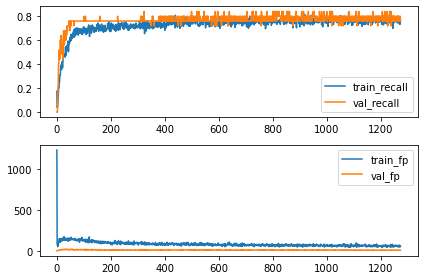

In [4]:
import matplotlib.pyplot as plt

# plot training and validation history
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['recall'], label='train_recall')
ax1.plot(history.history['val_recall'], label='val_recall')
ax2.plot(history.history['false_positives'], label='train_fp')
ax2.plot(history.history['val_false_positives'], label='val_fp')

ax1.legend()
ax2.legend()

plt.tight_layout();

### Evaluation

In [5]:
_, _, tr_recall, tr_fp = clf.evaluate(X_train, y_train, verbose=0)
_, _, test_recall, test_fp = clf.evaluate(X_test, y_test, verbose=0)
print('Train_recall: %.3f, Test_recall: %.3f' % (tr_recall, test_recall))
print('Train_fp: %.3f, Test_fp: %.3f' % (tr_fp, test_fp))

Train_recall: 0.841, Test_recall: 0.824
Train_fp: 51.000, Test_fp: 10.000


{'recall': 0.8235294117647058,
 'precision': 0.8484848484848485,
 'f1': 0.8358208955223881}

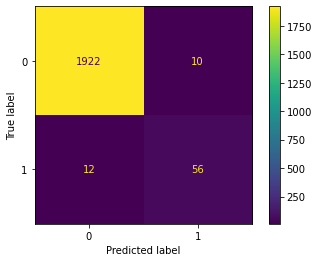

In [28]:
# Visualize the evaluation
hf.dl_evaluate(clf, X_test, y_test, cutoff=0.5)

In [19]:
# save the model
clf.save('dl_model')

INFO:tensorflow:Assets written to: dl_model\assets


In [20]:
# load the model 
# model = tf.keras.models.load_model('dl_model')